## Импорт библиотек

In [ ]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from IPython.display import set_matplotlib_formats

%matplotlib inline
matplotlib.rcParams['lines.linewidth'] = 2.0

import seaborn as sns

sns.reset_orig()
sns.set()

from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

main_rng = random.PRNGKey(42)

import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10, MNIST

DATASET_PATH = "../../data"
CHECKPOINT_PATH = "../../models"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

## Загружаем данные
### Тут можно и CIFAR10 сделать небольшими изменениями, но там с генерацией всё прям плохо выглядит, лучше пусть будет MNIST

In [ ]:
def img2np(img):
    img = np.array(img, dtype=np.float32) / 255. * 2. - 1.
    return img

def jax_to_torch(imgs):
    imgs = jax.device_get(imgs)
    imgs = torch.from_numpy(imgs.astype(np.float32))
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)[:, :, :, np.newaxis]
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

train_set = MNIST(root=DATASET_PATH, train=True, transform=img2np, download=True)
test_set = MNIST(root=DATASET_PATH, train=False, transform=img2np, download=True)

train_loader = data.DataLoader(train_set, batch_size=512, shuffle=True, drop_last=True, pin_memory=True, num_workers=4, collate_fn=np_collate, persistent_workers=True)
test_loader = data.DataLoader(test_set, batch_size=512, shuffle=False, drop_last=False, num_workers=4, collate_fn=np_collate)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(train_loader) * train_loader.batch_size

59904

## Энкодер и декодер для AE

In [ ]:
class Encoder(nn.Module):
    hidden_channels : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.hidden_channels, kernel_size=(4, 4), strides=2)(x)
        x = nn.silu(x)
        x = nn.Conv(features=self.hidden_channels, kernel_size=(2, 2), strides=1)(x)
        x = nn.silu(x)
        x = nn.Conv(features=self.hidden_channels, kernel_size=(3, 3), strides=2)(x)
        x = nn.silu(x)
        x = nn.Conv(features=2*self.hidden_channels, kernel_size=(2, 2), strides=1)(x)
        x = nn.silu(x)
        x = nn.Conv(features=2*self.hidden_channels, kernel_size=(1, 1))(x)
        x = nn.silu(x)
        # print("Encoder:", x.shape)
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=self.latent_dim)(x)
        # print("Encoder2:", x.shape)
        return x

In [ ]:
class Decoder(nn.Module):
    out_channels : int
    hidden_channels : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*7*7*self.hidden_channels)(x)
        # print("Decoder2:", x.shape)
        x = nn.silu(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], 7, 7, -1)
        x = nn.ConvTranspose(features=2*self.hidden_channels, kernel_size=(1, 1))(x)
        x = nn.silu(x)
        x = nn.ConvTranspose(features=2*self.hidden_channels, kernel_size=(2, 2), strides=(1, 1))(x)
        x = nn.silu(x)
        x = nn.ConvTranspose(features=self.hidden_channels, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.silu(x)
        x = nn.ConvTranspose(features=self.hidden_channels, kernel_size=(2, 2), strides=(1, 1))(x)
        x = nn.silu(x)
        x = nn.ConvTranspose(features=self.out_channels, kernel_size=(4, 4), strides=(2, 2))(x)
        # print("Decoder:", x.shape)
        x = nn.tanh(x)
        return x

In [ ]:
class AutoEncoder(nn.Module):
    hidden_channels: int
    latent_dim : int
    out_channels: int

    def setup(self):
        self.encoder = Encoder(hidden_channels=self.hidden_channels, latent_dim=self.latent_dim)
        self.decoder = Decoder(hidden_channels=self.hidden_channels, latent_dim=self.latent_dim, out_channels=self.out_channels)

    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

## Будем оптимизировать MSE

In [ ]:
def mse_reconstruction_loss(model, params, imgs):
    recon_imgs = model.apply({'params': params}, imgs)
    loss = ((recon_imgs - imgs) ** 2).mean(axis=0).sum()
    return loss

In [ ]:
class Trainer:
    def __init__(self, hidden_channels, latent_dim, out_channels, lr=1e-3, seed=42):
        self.hidden_channels = hidden_channels
        self.latent_dim = latent_dim
        self.out_channels = out_channels
        self.lr = lr
        self.seed = seed

        self.model = AutoEncoder(hidden_channels=self.hidden_channels, latent_dim=self.latent_dim, out_channels = self.out_channels)
        self.exmp_imgs = next(iter(train_loader))[0][:8]
        # print(len(self.exmp_imgs), type(self.exmp_imgs))
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}')

        self.compile_train_eval_functions()
        self.init_model()

    def compile_train_eval_functions(self):
        def train_step(state, imgs_batch):
            loss_fn = lambda params: mse_reconstruction_loss(self.model, params, imgs_batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)

        def eval_step(state, imgs_batch):
            return mse_reconstruction_loss(self.model, state.params, imgs_batch)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        params = self.model.init(init_rng, self.exmp_imgs)['params']

        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=1e-3,
            warmup_steps=100,
            decay_steps=100*len(train_loader),
            end_value=1e-4
        )
        optimizer = optax.chain(
            optax.clip(1.0),
            optax.adam(lr_schedule)
        )
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, test_loader, num_epochs=100):
        best_eval = 1e6
        losses_train_all = []
        losses_test_all = []
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            losses_train = []
            for batch in train_loader:
                imgs, _ = batch
                self.state, loss = self.train_step(self.state, imgs)
                losses_train.append(loss)
            losses_train_np = np.stack(jax.device_get(losses_train))
            avg_loss_train = losses_train_np.mean()
            losses_train_all.append(avg_loss_train)

            if epoch_idx % 10 == 0:
                losses_test = []
                batch_sizes = []
                for batch, _ in test_loader:
                    loss = self.eval_step(self.state, batch)
                    losses_test.append(loss)
                    batch_sizes.append(batch[0].shape[0])
                losses_test_np = np.stack(jax.device_get(losses_test))
                batch_sizes_np = np.stack(batch_sizes)

                # Taking weighted mean
                eval_loss = (losses_test_np * batch_sizes_np).sum() / batch_sizes_np.sum()
                if eval_loss < best_eval:
                    best_eval = eval_loss
                    self.save_model(step=epoch_idx)
                print("Epoch:", epoch_idx)
                print("Val loss:", eval_loss)

                losses_test_all.append(eval_loss)
        return np.stack(losses_train_all), np.stack(losses_test_all)

    def get_embeddings(self, data_loader):
        embeds = []
        for batch in test_loader:
            imgs, _ = batch
            embs_imgs = np.array(trainer.model_bd.encoder(imgs))
            for emb in embs_imgs:
                embeds.append(emb)
        return np.array(embeds)

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_', step=step, overwrite=True)

    def load_model(self):
        params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_')
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

## Поехали

In [ ]:
trainer = Trainer(hidden_channels=32, latent_dim=256, out_channels=1)
losses_train, losses_test = trainer.train_model(train_loader, test_loader, num_epochs=100)
trainer.load_model()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10
Val loss: 7.89104061126709
Epoch: 20
Val loss: 5.127088403701782
Epoch: 30
Val loss: 4.100903391838074
Epoch: 40
Val loss: 3.551239311695099
Epoch: 50
Val loss: 3.0143539190292357
Epoch: 60
Val loss: 2.69927636384964
Epoch: 70
Val loss: 2.49232931137085
Epoch: 80
Val loss: 2.322589600086212
Epoch: 90
Val loss: 2.21620489358902


Epoch: 100
Val loss: 2.1324389278888702


In [ ]:
trainer.model_bd = trainer.model.bind({'params': trainer.state.params})

## Глянем качество восстановления

(10, 28, 28, 1)


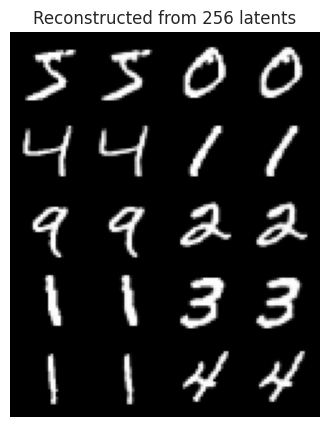

In [ ]:
input_imgs = img2np(train_set.data[:10])[:, :, :, np.newaxis]
print(input_imgs.shape)
reconst_imgs = trainer.model_bd(input_imgs)
imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title(f"Reconstructed from {trainer.latent_dim} latents")
plt.imshow(grid)
plt.axis('off')
plt.show()

## Попробуем сгенерировать семплы из нормального и униформного распределений

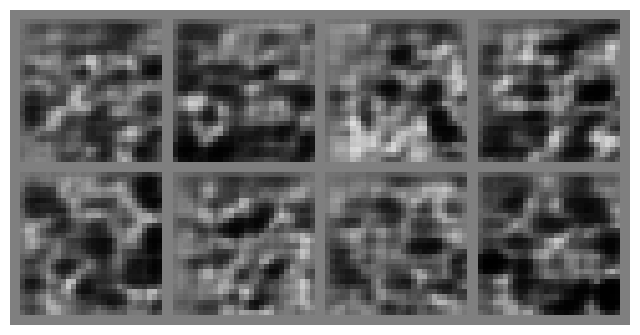

In [ ]:
rng = jax.random.PRNGKey(123)
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.normal(latent_noise, (8, trainer.latent_dim))
# Decode images -> Run model.decode method of the trainer's model with given parameters
imgs = trainer.model_bd.decoder(latent_vectors) # nn.apply(lambda model: model.decode(latent_vectors), trainer.model)({'params': trainer.state.params})

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

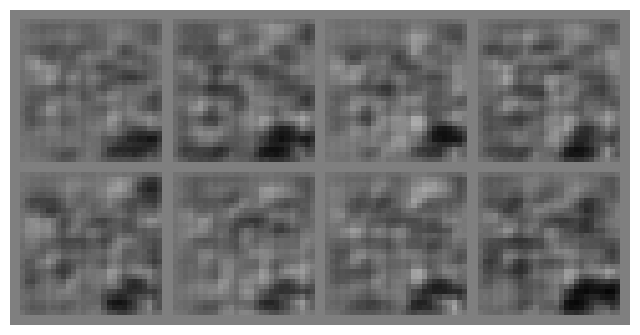

In [ ]:
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.uniform(latent_noise, (8, trainer.latent_dim))
# Decode images -> Run model.decode method of the trainer's model with given parameters
imgs = trainer.model_bd.decoder(latent_vectors) # nn.apply(lambda model: model.decode(latent_vectors), trainer.model)({'params': trainer.state.params})

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

## А теперь учтём распределение нашей выборки

In [ ]:
embeds = trainer.get_embeddings(train_loader)

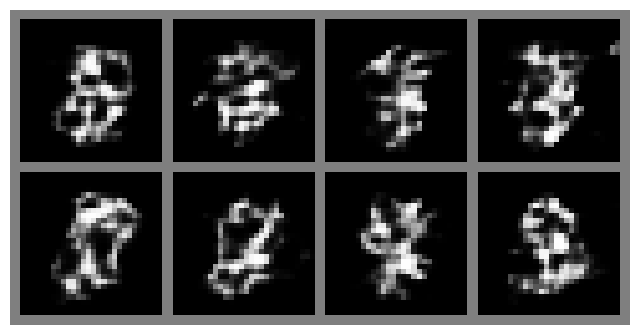

In [ ]:
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.normal(latent_noise, (8, trainer.latent_dim))
latent_vectors = embeds.mean(axis=0) + latent_vectors * embeds.std(axis=0)

imgs = trainer.model_bd.decoder(latent_vectors)

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

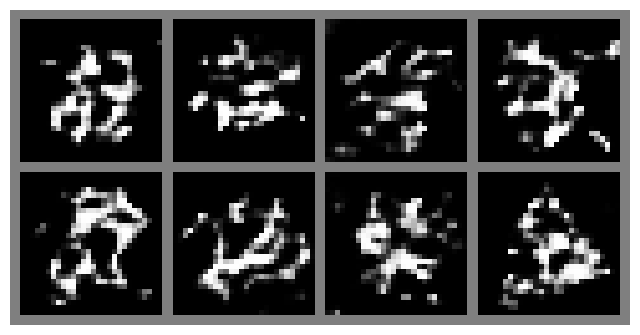

In [ ]:
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.uniform(latent_noise, (8, trainer.latent_dim))
latent_vectors = latent_vectors * (embeds.max(axis=0) - embeds.min(axis = 0)) + embeds.min(axis = 0)

imgs = trainer.model_bd.decoder(latent_vectors)

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

## Что ж, сильно лучше не стало...

Видно, что распределение у данных точно не такое, каким мы бы хотели его видеть (хотя учёт распределения данных и дал намного лучший результат, чем семплирование из стандартных версий распределений). Ни нормальное, ни униформное распределения не дали того, чего бы хотелось...

Давайте попробуем в этом убедиться на примере нескольких фичей

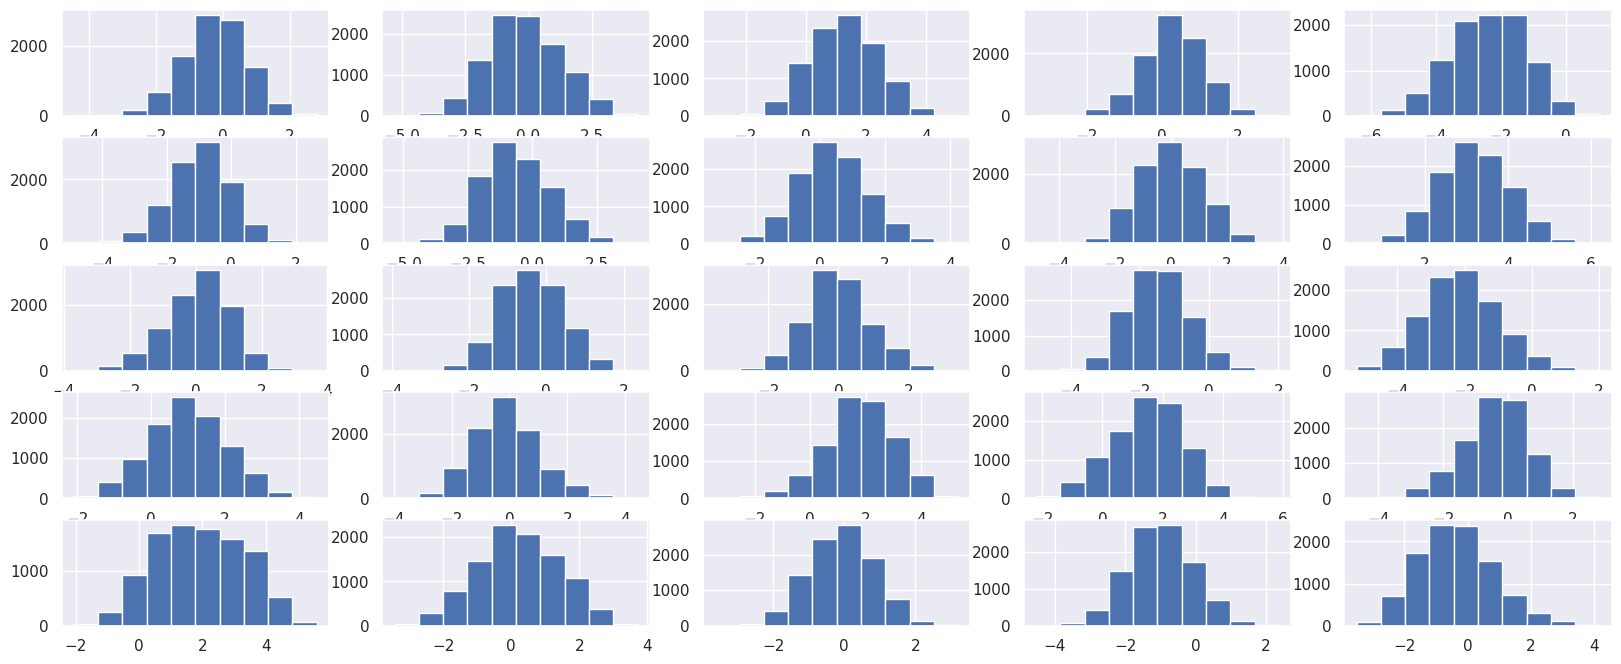

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 8))

for i, axis in enumerate(axes.flatten()):
  axis.hist(embeds[:, i])

Хоть иногда и получаем что-то похожее на нормальное распределение, у некоторых распределений видно хвосты, а какие-то распределения имеют довольно широкую "высокую" область у максимума. Это, конечно, не единственная причина (потому что при всём этом мы всё ещё достаточно близки к нормальному распределению) - при семплировании мы неявно полагаем нескореллированность фичей, и это предположение достаточно значительно стреляет.

P.S. были ещё попытки попробовать погенерировать картинки, используя CIFAR-10, но это мы опустили, потому что семплы там выглядели значительно хуже (что в целом понятно, конечно, - датасет намного сложнее).